In [2]:
import pandas as pd
from pandas_datareader import DataReader
import numpy as np
from datetime import datetime
#to plot within notebook
import matplotlib.pyplot as plt
import seaborn as sns
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
from sklearn.metrics import mean_squared_error,mean_absolute_error

#importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


import pandas as pd
from sklearn.ensemble import RandomForestClassifier as make_forest
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import numpy as np
import tqdm


In [3]:
start=datetime(2020,1,1)
end=datetime.now()
tsla=DataReader('TSLA','yahoo',start,end)
tsla['30 Day MA'] = tsla['Adj Close'].rolling(window=20).mean()
tsla['30 Day STD'] = tsla['Adj Close'].rolling(window=20).std()
tsla['Upper Band'] =tsla['30 Day MA'] + (tsla['30 Day STD'] * 2)
tsla['Lower Band'] =tsla['30 Day MA'] - (tsla['30 Day STD'] * 2)
tsla['daily return']=tsla['Adj Close'].pct_change()
tsla.head()

,High,Low,Open,Close,Volume,Adj Close,30 Day MA,30 Day STD,Upper Band,Lower Band,daily return
Date,,,,,,,,,,,
2020-01-02,86.139999,84.342003,84.900002,86.052002,47660500.0,86.052002,NaN,NaN,NaN,NaN,NaN
2020-01-03,90.800003,87.384003,88.099998,88.601997,88892500.0,88.601997,NaN,NaN,NaN,NaN,0.029633
2020-01-06,90.311996,88.000000,88.094002,90.307999,50665000.0,90.307999,NaN,NaN,NaN,NaN,0.019255
2020-01-07,94.325996,90.671997,92.279999,93.811996,89410500.0,93.811996,NaN,NaN,NaN,NaN,0.038801
2020-01-08,99.697998,93.646004,94.739998,98.428001,155721500.0,98.428001,NaN,NaN,NaN,NaN,0.049205


In [4]:
def relative_strength_idx(tsla, n=14):
    close = tsla['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

tsla['RSI'] = relative_strength_idx(tsla).fillna(0)

In [5]:
tsla=tsla.dropna()
tsla.head()

,High,Low,Open,Close,Volume,Adj Close,30 Day MA,30 Day STD,Upper Band,Lower Band,daily return,RSI
Date,,,,,,,,,,,,
2020-01-30,130.175995,123.599998,126.484001,128.162003,145028500.0,128.162003,104.512699,10.811539,126.135777,82.889621,0.102962,82.015651
2020-01-31,130.600006,126.503998,128.000000,130.113998,78596500.0,130.113998,106.715799,11.328712,129.373222,84.058376,0.015231,83.725834
2020-02-03,157.227997,134.703995,134.738007,156.000000,235325000.0,156.000000,110.085699,15.065039,140.215777,79.955621,0.198949,87.704668
2020-02-04,193.798004,166.776001,176.591995,177.412003,304694000.0,177.412003,114.440899,20.614853,155.670605,73.211194,0.137256,90.377937
2020-02-05,169.195999,140.822006,164.651993,146.940002,242119000.0,146.940002,117.097300,21.230541,159.558382,74.636217,-0.171758,69.123266


In [11]:
feats=tsla.columns
feats.tolist()

['High',
 'Low',
 'Open',
 'Close',
 'Volume',
 'Adj Close',
 '30 Day MA',
 '30 Day STD',
 'Upper Band',
 'Lower Band',
 'daily return',
 'RSI']

<AxesSubplot:>

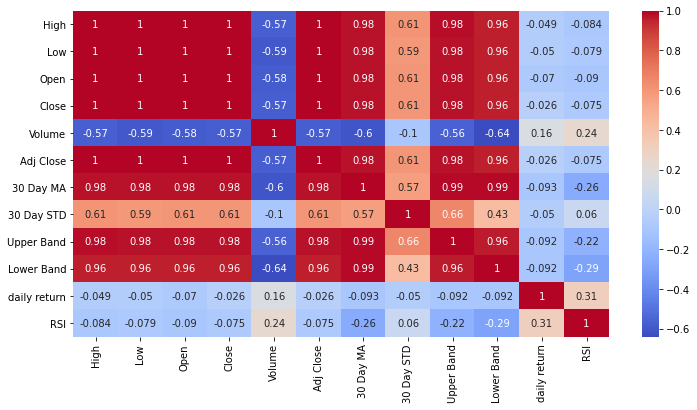

In [12]:
plt.figure(figsize=(12,6))
sns.heatmap(tsla.corr(),cmap='coolwarm',annot=True)

In [13]:
#dpecifying Dependent and Independent Variabels
X=tsla[['Open','High','Low','Close','Adj Close']]
y=tsla[['30 Day MA','30 Day STD','Upper Band','Lower Band','daily return','RSI']]
tsla.head()

,High,Low,Open,Close,Volume,Adj Close,30 Day MA,30 Day STD,Upper Band,Lower Band,daily return,RSI
Date,,,,,,,,,,,,
2020-01-30,130.175995,123.599998,126.484001,128.162003,145028500.0,128.162003,104.512699,10.811539,126.135777,82.889621,0.102962,82.015651
2020-01-31,130.600006,126.503998,128.000000,130.113998,78596500.0,130.113998,106.715799,11.328712,129.373222,84.058376,0.015231,83.725834
2020-02-03,157.227997,134.703995,134.738007,156.000000,235325000.0,156.000000,110.085699,15.065039,140.215777,79.955621,0.198949,87.704668
2020-02-04,193.798004,166.776001,176.591995,177.412003,304694000.0,177.412003,114.440899,20.614853,155.670605,73.211194,0.137256,90.377937
2020-02-05,169.195999,140.822006,164.651993,146.940002,242119000.0,146.940002,117.097300,21.230541,159.558382,74.636217,-0.171758,69.123266


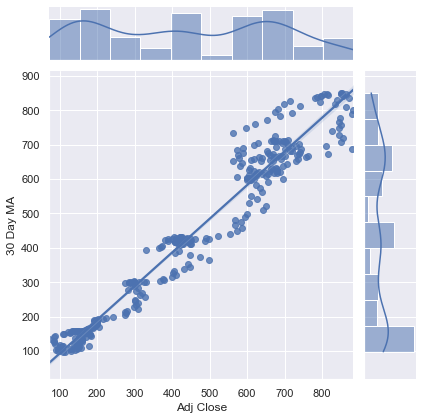

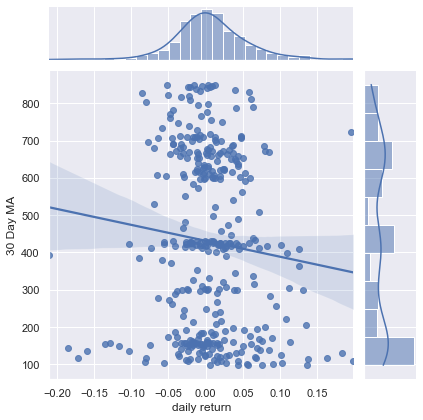

In [14]:
sns.set(color_codes=True)
sns.jointplot(x="Adj Close",y='30 Day MA',data=tsla,kind="reg")
sns.jointplot(x="daily return",y='30 Day MA',data=tsla,kind="reg")

In [43]:
y = tsla.drop('Adj Close',axis=1)
X = tsla['Adj Close'].values.reshape([-1,1])
X=pd.DataFrame(X)
print(X.shape,type(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [44]:
rf=RandomForestClassifier()
rf.fit(X_train.values,y_train)
y_predict=rf.predict(X_test)

ValueError: Unknown label type: 'continuous-multioutput'

In [34]:
from sklearn import tree

In [41]:
RForest=RandomForestClassifier(random_state=5)

In [42]:
model = RForest.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous-multioutput'

In [13]:
print('MAE:', mean_absolute_error(y_test, RForest.predict(X_test)))
print('MSE:', mean_squared_error(y_test, RForest.predict(X_test)))
print('RMSE:', np.sqrt(mean_squared_error(y_test, RForest.predict(X_test))))

MAE: 6.9124232575368065
MSE: 107.30819111994016
RMSE: 10.358966701362649


In [24]:
prediction=RForest.predict(X_test)

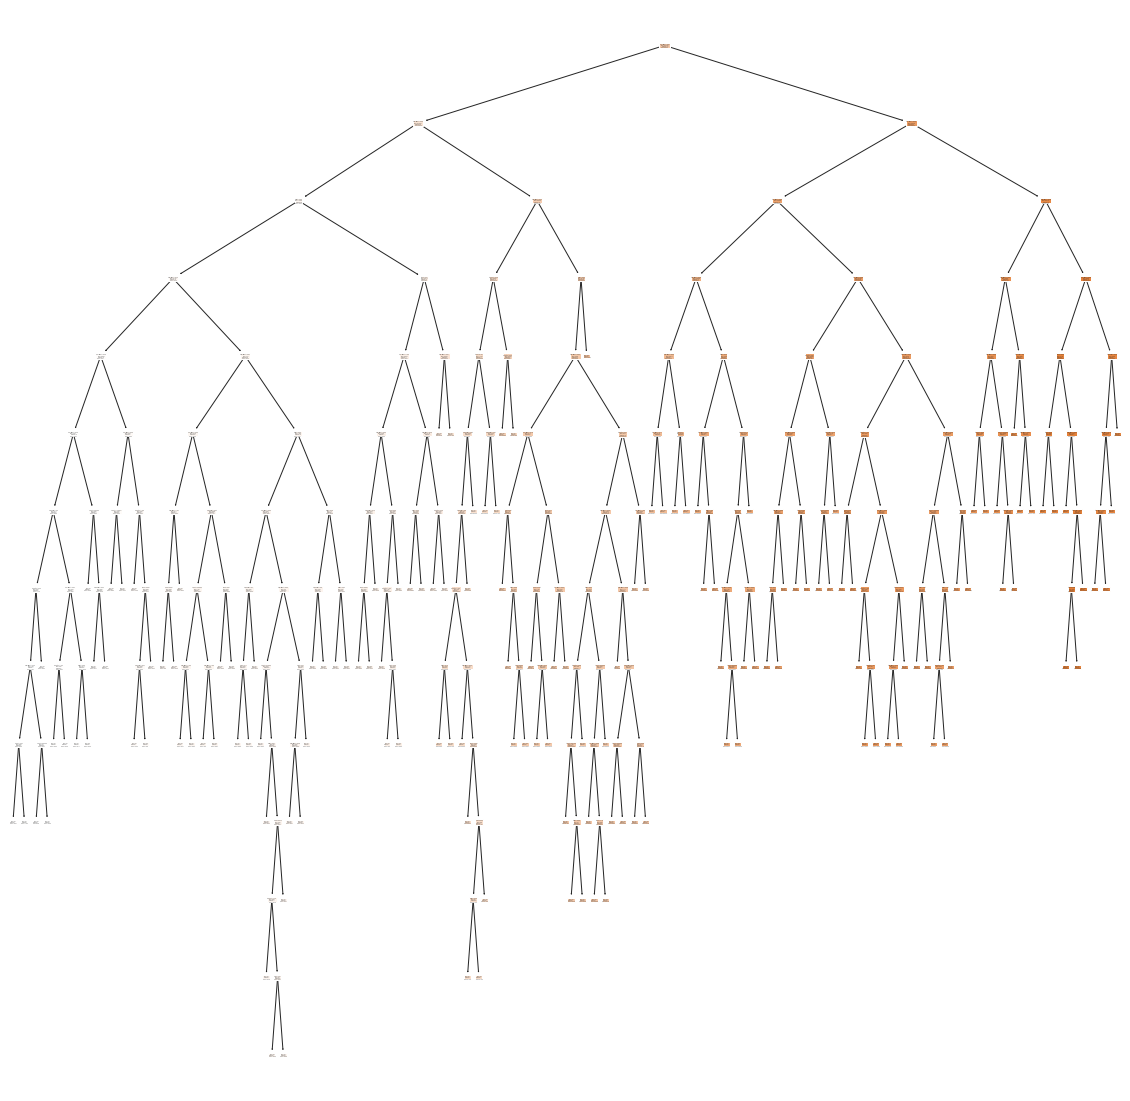

In [21]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(RForest.estimators_[0], feature_names=X.columns, filled=True)